# Make a catalog to cross-match to for astrometry

Gaia does not seem to have enough stars, nor  does 2MASS

VVV does, but the matches aren't good enough, so we need to use our own...

In [1]:
import numpy as np

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy.table import Table
from astropy.io import fits
from astropy import wcs
from astropy.wcs import WCS
import regions
from astroquery.vizier import Vizier

In [3]:
from astropy.visualization import quantity_support

In [4]:
%matplotlib inline
import pylab as pl

In [5]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [6]:
fov = regions.Regions.read(f'{basepath}/regions/nircam_fov.reg')

In [7]:
coord = fov[0].center
height = fov[0].height
width = fov[0].width
height, width = width, height # CARTA wrote it wrong
coord, width, height

(<SkyCoord (ICRS): (ra, dec) in deg
     (266.53496367, -28.71007499)>,
 <Quantity 161.9038 arcsec>,
 <Quantity 391.024 arcsec>)

In [8]:
Gaia.ROW_LIMIT = 10000
rslt = Gaia.query_object_async(coordinate=coord, width=width, height=height)

INFO: Query finished. [astroquery.utils.tap.core]


In [9]:
gaiacrds = SkyCoord(rslt['ra'], rslt['dec'], frame='icrs')
len(gaiacrds)

272

In [10]:
regs = regions.Regions([regions.PointSkyRegion(crd) for crd in gaiacrds])

In [11]:
regs.write(f'{basepath}/regions/gaia_sources.reg', overwrite=True)

In [12]:
Vizier.find_catalogs('2MASS Point Source')

OrderedDict([('II/246', </>), ('II/281', </>), ('J/ApJS/184/138', </>)])

In [13]:
Vizier.ROW_LIMIT = 5e4

In [14]:
galnuc2019 = Vizier.query_region(coordinates=coord, width=width, height=height, catalog=['J/A+A/631/A20'])[0]
galnuc2019[:3]

RAJ2000,e_RAJ2000,DEJ2000,e_DEJ2000,RAJdeg,e_RAJdeg,DEJdeg,e_DEJdeg,RAHdeg,e_RAHdeg,DEHdeg,e_DEHdeg,RAKsdeg,e_RAKsdeg,DEKsdeg,e_DEKsdeg,Jmag,e_Jmag,Hmag,e_Hmag,Ksmag,e_Ksmag,iJ,iH,iKs
deg,arcsec,deg,arcsec,deg,arcsec,deg,arcsec,deg,arcsec,deg,arcsec,deg,arcsec,deg,arcsec,mag,mag,mag,mag,mag,mag,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,uint8,uint8,uint8
266.51151,0.000000000,-28.757747,0.000000000,266.51151,0.001987759,-28.757747,0.002155650,266.51151,0.001987759,-28.757747,0.002155650,266.51151,0.001987759,-28.757747,0.002155650,12.67029,0.00486,12.22915,0.01243,12.19240,0.01123,2,2,2
266.52640,0.001296887,-28.748615,0.001615686,266.52640,0.001919700,-28.748616,0.002009142,266.52640,0.001989142,-28.748614,0.002159149,266.52640,--,-28.748615,--,13.64379,0.00700,12.82945,0.01289,12.60900,0.01718,2,2,2
266.52081,0.000648459,-28.747770,0.000807829,266.52081,0.001160735,-28.747769,--,266.52081,--,-28.747770,--,266.52081,--,-28.747770,--,14.04259,0.00401,13.46765,0.01227,13.46750,0.01181,2,2,2


In [15]:
galnuc2021 = Vizier.query_region(coordinates=coord, width=width, height=height, catalog=['J/A+A/653/A133'])[0]
galnuc2021[:3]

RAJ2000,e_RAJ2000,DEJ2000,e_DEJ2000,Jmag,e_Jmag,Hmag,e_Hmag,Ksmag,e_Ksmag,FJH,FHK,AJ1JH,e_AJ1JH,AH1JH,e_AH1JH,AH1HK,e_AH1HK,AK1HK,e_AK1HK,AH2HK,e_AH2HK,AK2HK,e_AK2HK
deg,arcsec,deg,arcsec,mag,mag,mag,mag,mag,mag,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
266.51151,0.000000000,-28.757747,0.000000000,12.67029,0.00486,12.22915,0.01243,12.19240,0.01123,1,1,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000
266.52640,0.001296887,-28.748615,0.001615686,13.64379,0.00700,12.82945,0.01289,12.60900,0.01718,1,1,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000
266.52081,0.000648459,-28.747770,0.000807829,14.04259,0.00401,13.46765,0.01227,13.46750,0.01181,1,1,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000


In [16]:
# FK5 because it says 'J2000' on the Vizier page (same as twomass)
galnuc2021_crds = SkyCoord(galnuc2021['RAJ2000'], galnuc2021['DEJ2000'], frame='fk5')

In [17]:
vvvdr2 = Vizier.query_region(coordinates=coord, width=width, height=height, catalog=['II/348/vvv2'])[0]
vvvdr2[:3]
len(vvvdr2)

4693

In [18]:
vvvdr2.write(f'{basepath}/regions/vvvdr2.fits', overwrite=True)

In [19]:
# FK5 because it says 'J2000' on the Vizier page (same as twomass)
vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5')

In [20]:
Vizier.ROW_LIMIT = 1e4
twomass = Vizier.query_region(coordinates=coord, width=width, height=height, catalog=['II/246'])[0]
twomass[:3]

RAJ2000,DEJ2000,_2MASS,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,Qflg,Rflg,Bflg,Cflg,Xflg,Aflg
deg,deg,,mag,mag,mag,mag,mag,mag,,,,,,
float64,float64,str17,float32,float32,float32,float32,float32,float32,str3,str3,str3,str3,uint8,uint8
266.546943,-28.752007,17461126-2845072,14.314,--,13.123,0.103,10.854,--,UAU,020,010,000,0,0
266.543681,-28.762333,17461048-2845443,16.551,--,13.405,0.074,11.001,0.043,UBA,022,011,0c0,0,0
266.543638,-28.753548,17461047-2845127,17.043,--,14.264,--,13.001,0.114,UUB,002,003,00c,0,0


In [21]:
twomass.meta['description'] = '2MASS Point Source Catalog'

In [22]:
twomass.write(f'{basepath}/regions/twomass.fits', overwrite=True)

In [23]:
# FK5 because it says 'J2000' on the Vizier page
twomass_crds = SkyCoord(twomass['RAJ2000'], twomass['DEJ2000'], frame='fk5')

# Test cross-match (to be put in the pipeline when it works)

In [24]:
from astropy.table import Table

In [25]:
filtername = 'f212n'
module = 'nrca'
catfile = f'{basepath}/{filtername.upper()}/pipeline/jw02221-o001_t001_nircam_clear-{filtername}-{module}_cat.ecsv'
imfile = f'{basepath}/{filtername.upper()}/pipeline/jw02221-o001_t001_nircam_clear-{filtername}-{module}_i2d.fits'
cat = Table.read(catfile)
cat.write(catfile.replace('ecsv', 'fits'), overwrite=True) # for CARTA viewing

In [26]:
cat[:3]

label,xcentroid,ycentroid,sky_centroid,aper_bkg_flux,aper_bkg_flux_err,aper30_flux,aper30_flux_err,aper50_flux,aper50_flux_err,aper70_flux,aper70_flux_err,aper_total_flux,aper_total_flux_err,aper30_abmag,aper30_abmag_err,aper50_abmag,aper50_abmag_err,aper70_abmag,aper70_abmag_err,aper_total_abmag,aper_total_abmag_err,aper30_vegamag,aper30_vegamag_err,aper50_vegamag,aper50_vegamag_err,aper70_vegamag,aper70_vegamag_err,aper_total_vegamag,aper_total_vegamag_err,CI_50_30,CI_70_50,CI_70_30,is_extended,sharpness,roundness,nn_label,nn_dist,isophotal_flux,isophotal_flux_err,isophotal_abmag,isophotal_abmag_err,isophotal_vegamag,isophotal_vegamag_err,isophotal_area,semimajor_sigma,semiminor_sigma,ellipticity,orientation,sky_orientation,sky_bbox_ll,sky_bbox_ul,sky_bbox_lr,sky_bbox_ur
,,,"deg,deg",Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,,,,,,,,pix,Jy,Jy,,,,,pix2,pix,pix,,deg,deg,"deg,deg","deg,deg","deg,deg","deg,deg"
int64,float64,float64,SkyCoord,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float32,int64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,SkyCoord,SkyCoord,SkyCoord,SkyCoord
1,5445.3328,9.3403,"266.5119930576015,-28.71584187734896",1.370933e-06,1.611778e-07,6.287080e-04,5.164152e-06,1.486255e-03,8.088094e-06,4.434067e-03,1.397058e-05,6.479502e-03,2.041521e-05,16.903878,0.008882,15.969767,0.005892,14.782994,0.003415,14.371146,0.003415,15.072668,0.008882,14.138557,0.005892,12.951784,0.003415,12.539936,0.003415,2.3640,2.9834,7.0527,True,0.484418,0.330504,4,28.243320,5.879686e-03,1.666915e-05,14.476615,0.003074,12.645405,0.003074,855.0,4.475867,3.071416,0.313783,56.564710,235.963098,"266.5119173046212,-28.716024081660404","266.5122848637437,-28.71602075992198","266.51191280124,-28.715640742121444","266.51228035901437,-28.715637420394447"
2,5833.5967,14.4471,"266.5120040475854,-28.712458761681894",7.274087e-07,1.443525e-07,2.988734e-06,5.916148e-07,7.846320e-06,9.204035e-07,2.092049e-05,2.065647e-06,3.057111e-05,3.018530e-06,22.711282,0.196095,21.663335,0.120428,20.598570,0.102235,20.186722,0.102235,20.880072,0.196095,19.832125,0.120428,18.767360,0.102235,18.355512,0.102235,2.6253,2.6663,6.9998,True,0.621510,-0.594348,58,30.537134,6.622127e-03,1.647986e-05,14.347506,0.002699,12.516296,0.002699,1257.0,14.285255,3.158275,0.778914,50.658771,230.057160,"266.51187861755926,-28.712730846592013","266.5123256348371,-28.712726806628588","266.51187186292543,-28.712155837309485","266.5123188777442,-28.712151797366904"
3,5723.4288,6.2094,"266.5119334919977,-28.71341931328076",9.341426e-08,2.450474e-08,6.489960e-05,1.309606e-06,1.362834e-04,1.947509e-06,2.173867e-04,2.765432e-06,3.176672e-04,4.041126e-06,19.369395,0.021691,18.563892,0.015406,18.056918,0.013725,17.645069,0.013725,17.538185,0.021691,16.732682,0.015406,16.225708,0.013725,15.813859,0.013725,2.0999,1.5951,3.3496,False,0.490064,-0.034066,70,19.595668,2.994767e-04,4.318097e-06,17.709093,0.015543,15.877883,0.015543,200.0,3.981571,2.080165,0.477552,-3.790541,175.607847,"266.5118978646814,-28.71352357266696","266.5120568053669,-28.71352213638206","266.5118949990034,-28.713279629331897","266.51205393931804,-28.713278193050126"


In [27]:
skycrds_cat = cat['sky_centroid']

In [28]:
idx, sidx, sep, sep3d = gaiacrds.search_around_sky(skycrds_cat, 0.2*u.arcsec)

In [29]:
len(idx)

96

In [30]:
dra = (skycrds_cat[idx].ra - gaiacrds[sidx].ra).to(u.arcsec)
ddec = (skycrds_cat[idx].dec - gaiacrds[sidx].dec).to(u.arcsec)

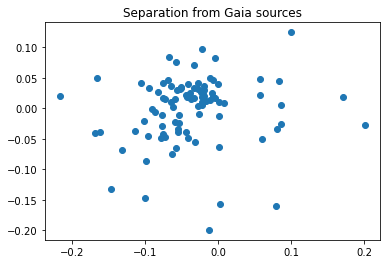

In [31]:
pl.title("Separation from Gaia sources")
pl.scatter(dra, ddec);

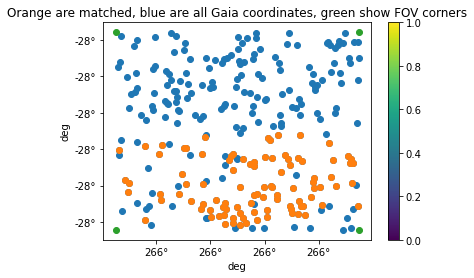

In [32]:
with quantity_support():
    pl.scatter(gaiacrds.ra, gaiacrds.dec)
    pl.scatter(gaiacrds.ra[sidx], gaiacrds.dec[sidx])
    pl.scatter([fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,
                fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,],
               [fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,]
              )
    pl.colorbar()
    pl.title("Orange are matched, blue are all Gaia coordinates, green show FOV corners")

In [33]:
idx, sidx, sep, sep3d = twomass_crds.search_around_sky(skycrds_cat, 0.2*u.arcsec)

In [34]:
len(idx)

176

In [35]:
dra = skycrds_cat[idx].ra - twomass_crds[sidx].ra
ddec = skycrds_cat[idx].dec - twomass_crds[sidx].dec

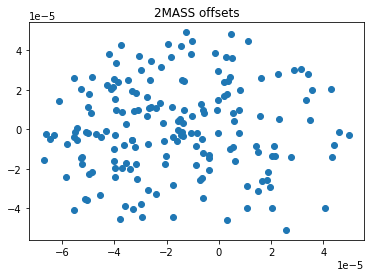

In [36]:
pl.title("2MASS offsets")
pl.scatter(dra, ddec);

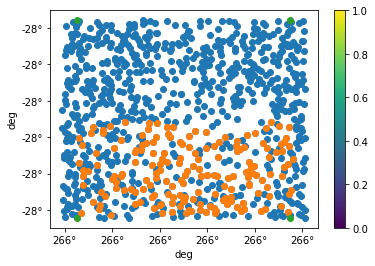

In [37]:
with quantity_support():
    pl.scatter(twomass_crds.ra, twomass_crds.dec)
    pl.scatter(twomass_crds.ra[sidx], twomass_crds.dec[sidx])
    pl.scatter([fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,
                fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,],
               [fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,]
              )
    pl.colorbar()

In [38]:
idx, sidx, sep, sep3d = galnuc2021_crds.search_around_sky(skycrds_cat, 0.2*u.arcsec)

In [39]:
len(idx)

11961

In [40]:
dra = (skycrds_cat[idx].ra - galnuc2021_crds[sidx].ra).to(u.arcsec)
ddec = (skycrds_cat[idx].dec - galnuc2021_crds[sidx].dec).to(u.arcsec)

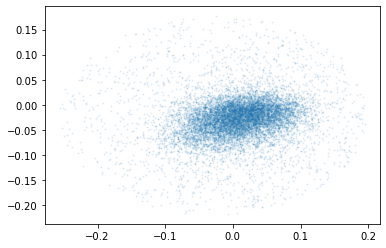

In [41]:
pl.scatter(dra, ddec, s=1, alpha=0.1)

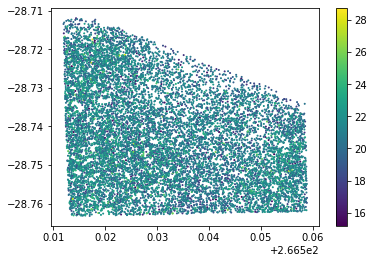

In [42]:
pl.scatter(skycrds_cat[idx].ra, skycrds_cat[idx].dec, c=cat['aper30_abmag'][idx], s=1)
pl.colorbar()

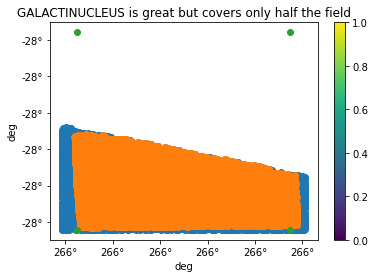

In [43]:
with quantity_support():
    pl.scatter(galnuc2021_crds.ra, galnuc2021_crds.dec)
    pl.scatter(galnuc2021_crds.ra[sidx], galnuc2021_crds.dec[sidx])
    pl.scatter([fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,
                fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,],
               [fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,]
              )
    pl.colorbar()
    pl.title("GALACTINUCLEUS is great but covers only half the field")

# VVV offsets

In [44]:
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(skycrds_cat, 0.2*u.arcsec)

In [45]:
len(idx)

1429

In [46]:
dra = (skycrds_cat[idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (skycrds_cat[idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)

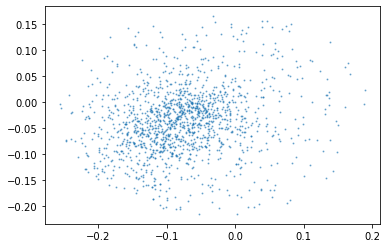

In [47]:
pl.scatter(dra, ddec, s=1, alpha=0.5)

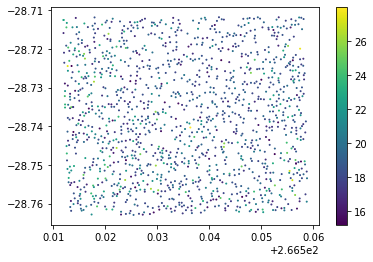

In [48]:
pl.scatter(skycrds_cat[idx].ra, skycrds_cat[idx].dec, c=cat['aper30_abmag'][idx], s=1)
pl.colorbar()

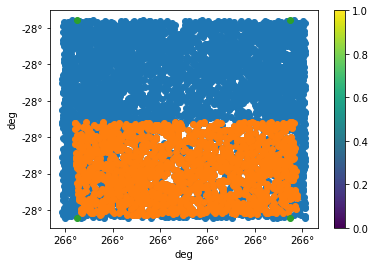

In [49]:
with quantity_support():
    pl.scatter(vvvdr2_crds.ra, vvvdr2_crds.dec)
    pl.scatter(vvvdr2_crds.ra[sidx], vvvdr2_crds.dec[sidx])
    pl.scatter([fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,
                fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,],
               [fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,]
              )
    pl.colorbar()

# VVV

VVV looks pretty good superposed on the images.

The offset is generally <0.2 arcsec, often <0.1, but there's a systematic shift.

The flux range that matches is:

F187N : ~ 500 - 3000 MJy/sr

F182M, F212N: seems ~same-ish

Actually looks same-ish for the long wave too

Argh, what's the MJy/sr conversion?

In [50]:
from astropy.wcs import WCS
from astropy.io import fits

In [51]:
ww =  WCS(fits.getheader(imfile, ext=('SCI', 1)))
pixscale = ww.proj_plane_pixel_area()

Set OBSGEO-B to   -20.664510 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526442456.371 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [52]:
import numpy as np

## Approximate Jy/beam

In [53]:
(u.MJy/u.sr * (2*np.pi * (8*np.log(2)) * 2.5**2 * pixscale)).to(u.Jy)

<Quantity 5.0354493e-06 Jy>

but that doesn't seem to work.

Empirically,

8.5e-5 Jy -> 1933 MJy/sr
1.1e-5 Jy ->  165 MJy/sr
2.1e-5 Jy ->  350 MJy/sr

So there are ~70 nJy / (MJy/sr)

In [54]:
1.1e-5 / 165

6.666666666666667e-08

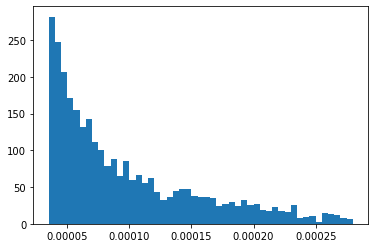

In [55]:
flux = (cat['aper30_abmag'].value * u.ABmag).to(u.Jy)
pl.hist(flux.value, bins=np.linspace(7e-8 * 500, 7e-8 * 4000))
sel = (flux > 7e-8*500*u.Jy) & (flux < 4000*7e-8*u.Jy)

In [56]:
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(skycrds_cat[sel], 0.4*u.arcsec)

In [57]:
len(idx)

857

In [58]:
dra = (skycrds_cat[sel][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (skycrds_cat[sel][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)

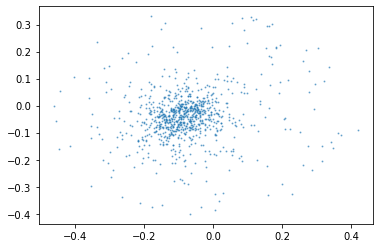

In [59]:
pl.scatter(dra, ddec, s=1, alpha=0.5)

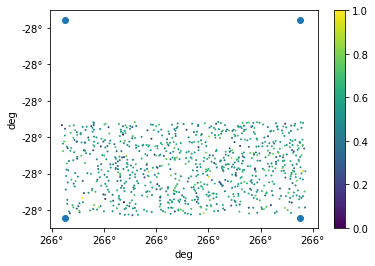

In [60]:
with quantity_support():
    pl.scatter(skycrds_cat[sel][idx].ra, skycrds_cat[sel][idx].dec, c=cat['aper30_abmag'][idx], s=1)
    pl.scatter([fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,
                fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,],
               [fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,]
              )
    pl.colorbar()

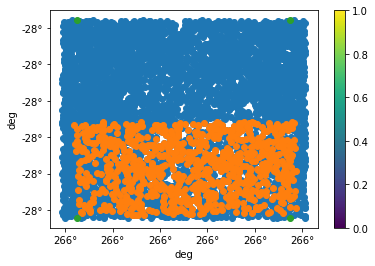

In [61]:
with quantity_support():
    pl.scatter(vvvdr2_crds.ra, vvvdr2_crds.dec)
    pl.scatter(vvvdr2_crds[sidx].ra, vvvdr2_crds[sidx].dec)
    pl.scatter([fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,
                fov[0].center.ra - fov[0].height/2,
                fov[0].center.ra + fov[0].height/2,],
               [fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec - fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,
                fov[0].center.dec + fov[0].width/2,]
              )
    pl.colorbar()

In [62]:
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(skycrds_cat[sel], 0.4*u.arcsec)
dra = (skycrds_cat[sel][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (skycrds_cat[sel][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)
print(np.median(dra), np.median(ddec))

-0.0867352arcsec -0.040828arcsec


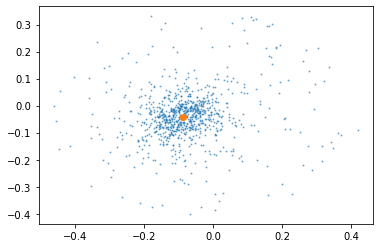

In [63]:
pl.scatter(dra, ddec, s=1, alpha=0.5)
pl.scatter(np.median(dra), np.median(ddec))

In [64]:
ww =  WCS(fits.getheader(imfile, ext=('SCI', 1)))
ww.wcs.crval = ww.wcs.crval - [np.median(dra).to(u.deg).value, np.median(ddec).to(u.deg).value]
with fits.open(imfile, mode='update') as hdulist:
    print(hdulist[1].header['CRVAL1'],
          hdulist[1].header['CRVAL2'])
    hdulist[1].header.update(ww.to_header())
    print(hdulist[1].header['CRVAL1'],
          hdulist[1].header['CRVAL2'])

266.53548009507 -28.737398163238
266.53550418818 -28.737386822132


Set OBSGEO-B to   -20.664510 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526442456.371 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


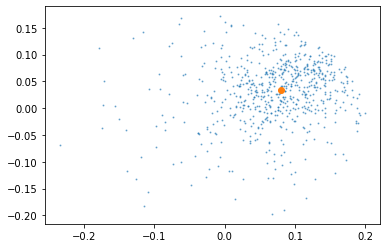

In [65]:
skycrds_cat_new = ww.pixel_to_world(cat['xcentroid'], cat['ycentroid'])

idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(skycrds_cat_new[sel], 0.2*u.arcsec)
dra = (skycrds_cat_new[sel][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (skycrds_cat_new[sel][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)

pl.scatter(dra, ddec, s=1, alpha=0.5)
pl.scatter(np.median(dra), np.median(ddec))

# Check what's happening in the overlap zones

In [66]:
from astropy import wcs

In [67]:
import regions
module_overlap = regions.Regions.read(f'{basepath}/regions/overlap_region.reg')
module_overlap

<Regions([<RectangleSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (266.535674, -28.71300934)>, width=11.3759 arcsec, height=150.5041 arcsec, angle=0.0 deg)>])>

In [68]:
import warnings

In [69]:
def check_overlap_zone(filtername = 'f212n'):
    fig = pl.figure(1, figsize=(10,5))
    pl.suptitle(filtername)
    
    ax1 = pl.subplot(1,2,1)
    ax2 = pl.subplot(1,2,2)

    for module in ('nrca', 'nrcb'):
        catfile = f'{basepath}/{filtername.upper()}/pipeline/jw02221-o001_t001_nircam_clear-{filtername}-{module}_cat.ecsv'
        imfile = f'{basepath}/{filtername.upper()}/pipeline/jw02221-o001_t001_nircam_clear-{filtername}-{module}_i2d.fits'
        cat = Table.read(catfile)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            ww = wcs.WCS(fits.getheader(imfile, ext=('SCI', 1)))
        
        skycrds_cat = cat['sky_centroid']
        realigned_skycrds = ww.pixel_to_world(cat['xcentroid'], cat['ycentroid'])
        
        for crds, ax, title in [(skycrds_cat, ax1, 'original'),
                                (realigned_skycrds, ax2, 'realigned')]:
            ax.set_title(title)
            sel = module_overlap[0].contains(crds, ww)

            idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(crds, 0.3*u.arcsec)

            dra_all = (crds[idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
            ddec_all = (crds[idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)

            idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(crds[sel], 0.3*u.arcsec)

            dra = (crds[sel][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
            ddec = (crds[sel][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)

            ax.axhline(0, color='k', linestyle=':')
            ax.axvline(0, color='k', linestyle=':')
            ax.scatter(dra_all, ddec_all, s=1, alpha=0.2, label=module)
            ax.scatter(dra, ddec, s=3, alpha=0.5, marker='s', label=module)
            ax.scatter(np.median(dra), np.median(ddec), marker='x', s=100)
            ax.axis([-0.3, 0.3, -0.3, 0.3])
    return fig

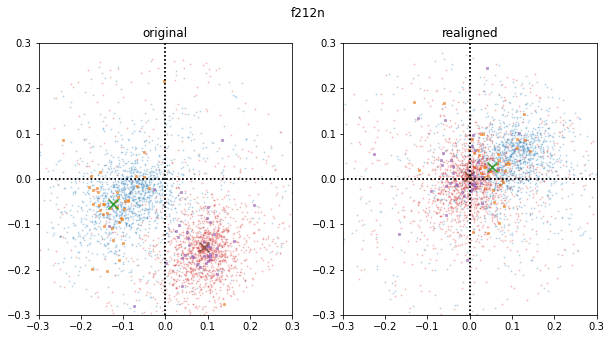

In [70]:
check_overlap_zone('f212n');

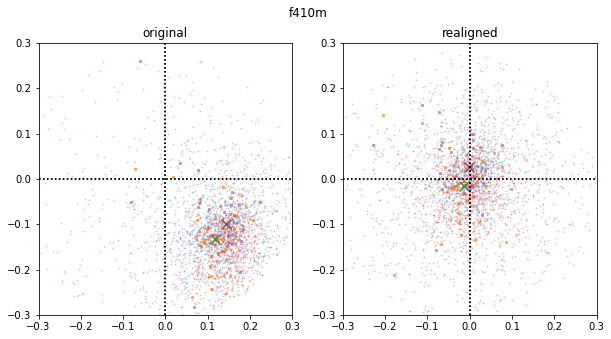

In [71]:
check_overlap_zone('f410m');

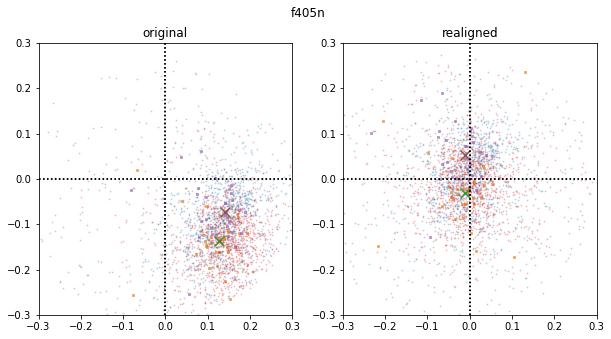

In [72]:
check_overlap_zone('f405n');

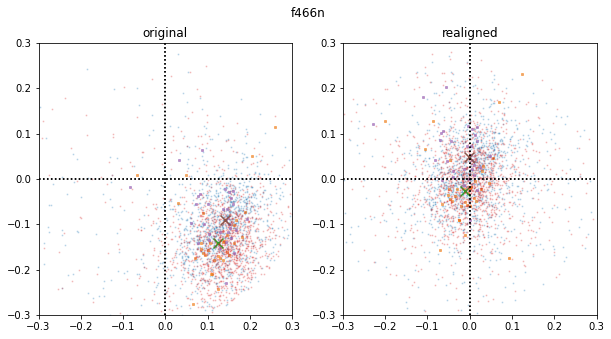

In [73]:
check_overlap_zone('f466n');

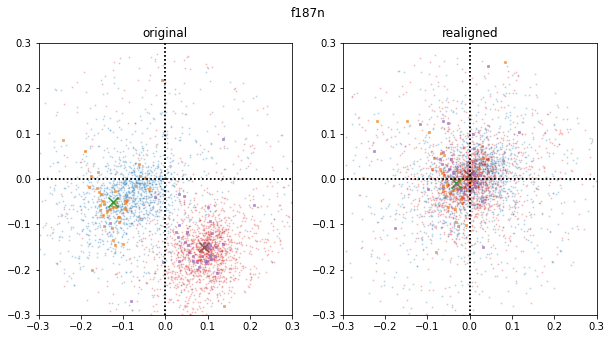

In [74]:
check_overlap_zone('f187n');

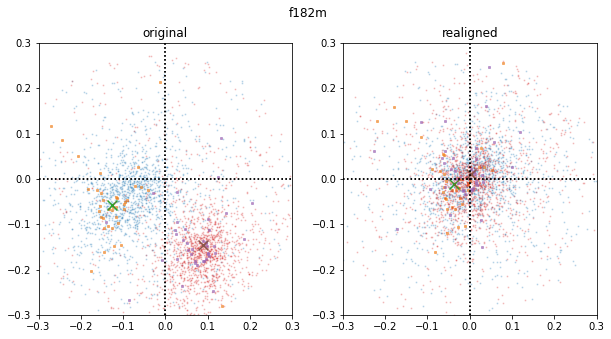

In [75]:
check_overlap_zone('f182m');

# "Production Run" test 

In [76]:
%run $basepath/reduction/align_to_catalogs.py

<Figure size 432x288 with 0 Axes>

In [77]:
realign_to_vvv()

Before realignment, offset is 0.08535500687685271 arcsec, 0.039601011788192864 arcsec
CRVAL before 266.53550418818 -28.737386822132
CRVAL after 266.53548047846 -28.737397822413
After realignment, offset is 0.001321870126957947 arcsec, 0.0011792251271458554 arcsec
CRVAL before 266.53548047846 -28.737397822413
CRVAL after 266.53548011127 -28.737398149976
After re-realignment, offset is 5.833526302012615e-05 arcsec, 4.774315343070157e-05 arcsec


[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2b27472b9040>, <astropy.io.fits.hdu.image.ImageHDU object at 0x2b27471d3490>, <astropy.io.fits.hdu.image.ImageHDU object at 0x2b27471f0d30>, <astropy.io.fits.hdu.image.ImageHDU object at 0x2b27471f05e0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x2b27471f0e80>, <astropy.io.fits.hdu.image.ImageHDU object at 0x2b27472c4220>, <astropy.io.fits.hdu.image.ImageHDU object at 0x2b27472c4070>, <astropy.io.fits.hdu.image.ImageHDU object at 0x2b27472c4580>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b27472c4b20>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b27472c4640>]

In [78]:
main()

f182m nrca
Before realignment, offset is 0.0013297704185788461 arcsec, -0.0003513571449786923 arcsec
CRVAL before 266.53547934188 -28.737397503648
CRVAL after 266.5354789725 -28.737397406049
After realignment, offset is -0.0013297723626237712 arcsec, 0.00035135564218080617 arcsec
CRVAL before 266.5354789725 -28.737397406049
CRVAL after 266.53547934188 -28.737397503648
After re-realignment, offset is -0.0001198217205455876 arcsec, 1.832592317896342e-05 arcsec
f182m nrcb
Before realignment, offset is 0.0013849009746991214 arcsec, 0.0011596912166567108 arcsec
CRVAL before 266.53552332201 -28.688869968166
CRVAL after 266.53552293732 -28.688870290302
After realignment, offset is -0.0013848727348886314 arcsec, -0.0011596912102618262 arcsec
CRVAL before 266.53552293732 -28.688870290302
CRVAL after 266.53552332201 -28.688869968166
After re-realignment, offset is -9.550274171488127e-06 arcsec, 9.879180993266345e-05 arcsec
f187n nrca
Before realignment, offset is 0.0016395643115174607 arcsec, -0

In [79]:
%run $basepath/reduction/align_to_catalogs.py

In [80]:
merge_a_plus_b('f410m')

Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [81]:
merge_a_plus_b('f212n', parallel=True)

Set OBSGEO-B to   -20.664510 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526442456.371 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.665528 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526454427.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.664510 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526442456.371 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/blue/adamginsburg/adamginsburg/repos/reproject/reproject/spherical_intersect/core.py:47: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn("The reproject_exact function currently has precision "
/blue/adamginsburg/adamginsburg/repos/reproject/reproject/spherical_intersect/core.py:47: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn("The reproject_exact function currently has precision "

# TEST aligning using tweakreg

In [82]:
from tweakwcs import JWSTgWCS, align_wcs, JWSTWCSCorrector, FITSWCSCorrector
from astropy.table import Table
from jwst.datamodels import ImageModel

# to update FITS WCS of the data models next import
# requires installing dev version of the pipeline
from jwst.assign_wcs.util import update_fits_wcsinfo


# This only works with L2 files

In [83]:
dm1 = ImageModel(imfile)
dm1.meta.wcs.available_frames

['detector', 'world']

In [84]:
imcat1 = cat
imcat1['x'] = imcat1['xcentroid']
imcat1['y'] = imcat1['ycentroid']
refcat = vvvdr2
refcat['RA'] = refcat['RAJ2000']
refcat['DEC'] = refcat['DEJ2000']

corr1 = FITSWCSCorrector(dm1.get_fits_wcs(),# dm1.meta.wcsinfo.instance,
                 meta={'catalog': imcat1, 'group_id': 1})

# align images to the reference catalog:
aligned_cat = align_wcs([corr1,], refcat=refcat) # + add other arguments as needed - see docs

2022-10-28 21:46:41,725 - stpipe - WARNING - /orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/wcs/wcs.py:725: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.528470 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.664510 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526442456.371 from OBSGEO-[XYZ]'.
  warnings.warn(

2022-10-28 21:46:41,728 - stpipe - INFO -  
2022-10-28 21:46:41,729 - stpipe - INFO - ***** tweakwcs.imalign.align_wcs() started on 2022-10-28 21:46:41.728089
2022-10-28 21:46:41,729 - stpipe - INFO -       Version 0.8.0
2022-10-28 21:46:41,730 - stpipe - INFO -  
2022-10-28 21:46:42,488 - stpipe - INFO - Aligning image catalog 'GROUP ID: 1' to the reference catalog.
2022-10-28 21:46:42,500 - stpipe - INFO - Matching sources from 'Unknown' catalog with sources from the reference 'II/348/vvv2' catalog.
2022-10-28 21:46:42,501 - stpipe - INFO - Computing initial guess for X and Y shifts...
2022-10-28 21:46:44,203 - stpipe - INFO - Found initi

In [85]:
dm1.meta.wcs = corr1.wcs
update_fits_wcsinfo(dm1, npoints=16) # <- update FITS WCS too (optionally). Repeat for each model below

# save image models to different files but one can also overwrite existing models:
#dm1.write(imfile.replace(".fits", "_wcscorrected_vvv.fits"))

AttributeError: 'WCS' object has no attribute 'to_fits_sip'

# Crossmatch F212N with VVV, then we'll save that and use it as our reference case


Work done Oct 20, 2022

Idea is to establish a new and *usable* master table, since VVV is mostly saturated.

In [ ]:
basepath = '/blue/adamginsburg/adamginsburg/jwst/brick'

In [ ]:
cd $basepath

In [ ]:
filtername = 'f212n'
module = 'nrca'
catfile = f'{basepath}/{filtername.upper()}/pipeline/jw02221-o001_t001_nircam_clear-{filtername}-{module}_cat.ecsv'
imfile = f'{basepath}/{filtername.upper()}/pipeline/jw02221-o001_t001_nircam_clear-{filtername}-{module}_i2d.fits'
cat = Table.read(catfile)
#cat.write(catfile.replace('ecsv', 'fits'), overwrite=True) # for CARTA viewing

Catalogs:

 * F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-merged_cat.ecsv
 * F212N/f212n_?merged?_crowdsource.fits doesn't exist yet
 * F212N/f212n_?merged?_daophot_iterative.fits doesn't exist yet

In [ ]:
# TODO: replace nrca w/full

crowdtbl = Table.read('F212N/f212n_nrca_crowdsource.fits')
crowdheader = fits.getheader('F212N/f212n_nrca_crowdsource.fits')
daobasictbl = Table.read('F212N/f212n_nrca_daophot_basic.fits')
daoitertbl = Table.read('F212N/f212n_nrca_daophot_iterative.fits')
len(crowdtbl), len(daobasictbl), len(daoitertbl)

In [ ]:
if 'skycoord' not in crowdtbl.colnames:
    print ("Swapping coords")
    # I've now fixed crowdtbl to include skycoord, but it hasn't run yet
    ww = wcs.WCS(crowdheader)
    # crowdtbl are still backwards now
    crowdtbl['skycoord'] = ww.pixel_to_world(crowdtbl['y'], crowdtbl['x'])

In [ ]:
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(daobasictbl['skycoord_centroid'], 0.5*u.arcsec)
dra = (daobasictbl['skycoord_centroid'][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (daobasictbl['skycoord_centroid'][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)
print(np.median(dra), np.median(ddec))

In [ ]:
pl.title("Offsets with DAO Basic table")
pl.scatter(dra, ddec, s=1, alpha=0.5)
pl.scatter(np.median(dra), np.median(ddec));

In [ ]:
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(daoitertbl['skycoord_centroid'], 0.5*u.arcsec)
dra = (daoitertbl['skycoord_centroid'][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (daoitertbl['skycoord_centroid'][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)
print(np.median(dra), np.median(ddec))

In [ ]:
pl.title("Offsets with DAO Iter table")
pl.scatter(dra, ddec, s=1, alpha=0.5)
pl.scatter(np.median(dra), np.median(ddec));

In [ ]:
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(crowdtbl['skycoord'], 0.5*u.arcsec)
dra = (crowdtbl['skycoord'][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (crowdtbl['skycoord'][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)
print(np.median(dra), np.median(ddec))

In [ ]:
pl.title("Offsets with Crowdsource table")
pl.scatter(dra, ddec, s=1, alpha=0.5)
pl.scatter(np.median(dra), np.median(ddec));

### Intermediate conclusions:

The iter table performed best but still quite poorly.  Only matches within <0.15 arcsec are remotely valid, so more source rejection is needed to get a good result.

In [ ]:
satstarcat = Table.read('F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-merged_i2d_satstar_catalog.fits')
if 'skycoord_fit' not in satstarcat.colnames:
    ww = WCS(fits.getheader('F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-merged_i2d.fits', ext=('SCI', 1)))
    satstarcat['skycoord_fit'] = ww.pixel_to_world(satstarcat['x_fit'], satstarcat['y_fit'])
    satstarcat.write('F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-merged_i2d_satstar_catalog.fits', overwrite=True)
satstarcat[:5]

### Try to reject sources near saturated sources (about 0.4" in F4* and 0.95" (?!?!) in F1*)

In [ ]:
satcrd = satstarcat['skycoord_fit']
idx_s, sidx_s, sep_s, sep3d_s = satcrd.search_around_sky(daoitertbl['skycoord_centroid'], 0.95*u.arcsec)
len(idx_s), len(sidx_s), len(sep_s), len(sep3d_s)

In [ ]:
inds = np.arange(len(daoitercrd))
unsat_inds = inds[~np.in1d(inds, idx_s)]
#daoitercrd_nosat = daoitercrd[unsat_inds]
daoitertbl_nosat = daoitertbl[unsat_inds]

In [ ]:
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(daoitertbl['skycoord_centroid'], 0.5*u.arcsec)
sat_idx = np.isin(idx, idx_s)
dra = (daoitertbl['skycoord_centroid'][idx].ra - vvvdr2_crds[sidx].ra).to(u.arcsec)
ddec = (daoitertbl['skycoord_centroid'][idx].dec - vvvdr2_crds[sidx].dec).to(u.arcsec)
dra_s = (daoitertbl['skycoord_centroid'][idx[sat_idx]].ra - vvvdr2_crds[sidx[sat_idx]].ra).to(u.arcsec)
ddec_s = (daoitertbl['skycoord_centroid'][idx[sat_idx]].dec - vvvdr2_crds[sidx[sat_idx]].dec).to(u.arcsec)
print(np.median(dra), np.median(ddec))

In [ ]:
pl.title("Offsets with DAO Iter table (saturated in orange)")
pl.scatter(dra, ddec, s=1, alpha=0.5)
pl.scatter(dra_s, ddec_s, s=2, alpha=1)
pl.scatter(np.median(dra), np.median(ddec));

## Try to match saturated star centroids

In [ ]:
satcrd = satstarcat['skycoord_fit']
idx_s, sidx_s, sep_s, sep3d_s = satcrd.search_around_sky(vvvdr2_crds, 0.5*u.arcsec)
dra_s = (satcrd[sidx_s].ra - vvvdr2_crds[idx_s].ra).to(u.arcsec)
ddec_s = (satcrd[sidx_s].dec - vvvdr2_crds[idx_s].dec).to(u.arcsec)
len(idx_s), len(satcrd), len(vvvdr2_crds)

In [ ]:
pl.title("Offsets from saturated stars")
pl.scatter(dra_s, ddec_s, s=1, alpha=0.5)
pl.scatter(np.median(dra_s), np.median(ddec_s));

In [ ]:
# for each coordinate in DAO catalog, find VVV match (for plotting)
daoitercrd_nosat = daoitertbl_nosat['skycoord_centroid']
idx, sidx, sep, sep3d = daoitercrd_nosat.search_around_sky(vvvdr2_crds, 0.5*u.arcsec)
dra = (daoitercrd_nosat[sidx].ra - vvvdr2_crds[idx].ra).to(u.arcsec)
ddec = (daoitercrd_nosat[sidx].dec - vvvdr2_crds[idx].dec).to(u.arcsec)
len(idx), len(daoitercrd), len(vvvdr2_crds)

In [ ]:
pl.title("Offsets b/w DAO Iter & VVV (starting w/DAO Iter) stars")
pl.scatter(dra, ddec, s=1, alpha=0.5)
bright = daoitertbl_nosat['flux_fit'][sidx] > 1e4
pl.scatter(dra[bright], ddec[bright], s=1, alpha=0.5)
pl.scatter(dra_s, ddec_s, s=2, alpha=1)
pl.scatter(np.median(dra), np.median(ddec));

In [ ]:
pl.title("Scatterplot to see what flux level results in good matches")
pl.scatter((dra**2 + ddec**2)**0.5, daoitertbl_nosat['flux_fit'][sidx], s=1)
pl.semilogy();
pl.axhline(1e4, color='k', linestyle='--');

In [ ]:
# for each coordinate in DAO catalog, find VVV match (for saving)
daoitercrd_nosat = daoitertbl_nosat['skycoord_centroid']
bright = daoitertbl_nosat['flux_fit'] > 1e4
idxd, sepd, _ = daoitercrd_nosat[bright].match_to_catalog_sky(vvvdr2_crds)

drad = (daoitercrd_nosat[bright].ra - vvvdr2_crds[idxd].ra).to(u.arcsec)
ddecd = (daoitercrd_nosat[bright].dec - vvvdr2_crds[idxd].dec).to(u.arcsec)

# then, for each vvv object, find the closest DAO
idxv, sepv, _ = vvvdr2_crds.match_to_catalog_sky(daoitercrd_nosat[bright])
drav = (daoitercrd_nosat[bright][idxv].ra - vvvdr2_crds.ra).to(u.arcsec)
ddecv = (daoitercrd_nosat[bright][idxv].dec - vvvdr2_crds.dec).to(u.arcsec)

len(idxd), len(idxv), bright.sum(), len(vvvdr2_crds)

In [ ]:
pl.title("Offsets b/w DAO Iter & VVV matches")
pl.scatter(drad, ddecd, s=1, alpha=0.5)
pl.scatter(drav, ddecv, s=1, alpha=0.5)
pl.scatter(np.median(drad), np.median(ddecd));
pl.scatter(np.median(drav), np.median(ddecv));
pl.scatter(np.median(drad[sepd<0.15*u.arcsec]), np.median(ddecd[sepd<0.15*u.arcsec]));
pl.scatter(np.median(drav[sepv<0.15*u.arcsec]), np.median(ddecv[sepv<0.15*u.arcsec]));
pl.axhline(0, color='k', linestyle='--', zorder=-5)
pl.axvline(0, color='k', linestyle='--', zorder=-5);
pl.axis([-0.5,0.5,-0.5,0.5])

In [ ]:
Table.read('F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-merged_vvvcat.ecsv').write('F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-merged_vvvcat.fits')

# Conclusions again: There's no offset?

So, what the hell?  Why do the catalogs _look_ so offset when overlaid on the data?

Maybe it's just that the catalogs have never run to completion on the final data.